## Deep learning/Reinforcement learning in Time series data: Stock price verion

Our goal is to predict close price using our model from previous input <br>
Episode one: https://www.kaggle.com/peraktong/transformer-ts   <br>
Please let me know if you have any question.   <br>
Thanks to this useful link : https://www.tensorflow.org/tutorials/text/transformer   <br>
Thanks to this useful link: https://www.kaggle.com/itoeiji/deep-reinforcement-learning-on-stock-data  <br>
Thanks to this useful link: https://towardsdatascience.com/aifortrading-2edd6fac689d <br>
Thanks to this useful link: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial <br>
Thanks to this useful link: https://rubikscode.net/2019/07/08/deep-q-learning-with-python-and-tensorflow-2-0/ <br>

In [15]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import gc
import json
plot_path = "plots/"




In [16]:

# Real server data (Unsupervised)

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)






['.ipynb_checkpoints',
 'cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [17]:
if True:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    


names_array = list(df.keys())[1:]

In [27]:

df_cif = df[["cif","cif_open","cif_close","cif_max","cif_min"]]
df_cif.head()

,cif,cif_open,cif_close,cif_max,cif_min
0,5230362.0,5230362.0,5230362.0,5230362.0,5230362.0
1,5430718.0,5430718.0,5430718.0,5430718.0,5430718.0
2,5352478.0,5352478.0,5352478.0,5352478.0,5352478.0
3,5247694.0,5247694.0,5247694.0,5247694.0,5247694.0
4,5197260.0,5197260.0,5197260.0,5197260.0,5197260.0



## Let's try the Q-net <br>
In Q-learning we learn the value of taking an action from a given state. Q-value is the expected return after taking the action. We will use Rainbow which is a combination of seven Q learning algorithms.

In [30]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['cif'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['cif'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['cif'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['cif'] - self.data.iloc[(self.t-1), :]['cif'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done

In [31]:


df_cif["Date"] = pd.to_datetime(df["time_stamp"])
data = df_cif.set_index('Date')

env = Environment1(df)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    #print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<ipython-input-31-4f5991c0d7ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cif["Date"] = pd.to_datetime(df["time_stamp"])


In [32]:

delta_split = int(df_cif.shape[0]*0.7)

train = df_cif[:delta_split]
test = df_cif[delta_split:]
print("Training date length",len(train),"testing date length", len(test))

Training date length 29232 testing date length 12529


In [37]:
import chainer
import chainer.functions as F
import chainer.links as L
import copy
import time



def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    # GPU Option
    #Q.to_gpu()
    
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)
    
    # Hyper-parameters
    epoch_num = 25
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 3


    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards


In [38]:
# Let's do it!
Q, total_losses, total_rewards = train_dqn(Environment1(train))

3	0.0999999999999992	87693	-12339.666666666666	22818990341918.066	799.9326732158661
6	0.0999999999999992	175386	-356.6666666666667	281277.8843839967	1120.1894581317902
9	0.0999999999999992	263079	-294.6666666666667	369.1124516561318	1200.4283833503723
12	0.0999999999999992	350772	-358.3333333333333	88907.17524762893	1089.7920355796814
15	0.0999999999999992	438465	-264.6666666666667	301.8085227038734	1213.9496490955353
18	0.0999999999999992	526158	-272.6666666666667	299.5712746389094	1190.9892721176147
21	0.0999999999999992	613851	-268.6666666666667	296.9731052965464	1214.0719451904297
24	0.0999999999999992	701544	-292.6666666666667	305.47637595236233	1181.7887060642242


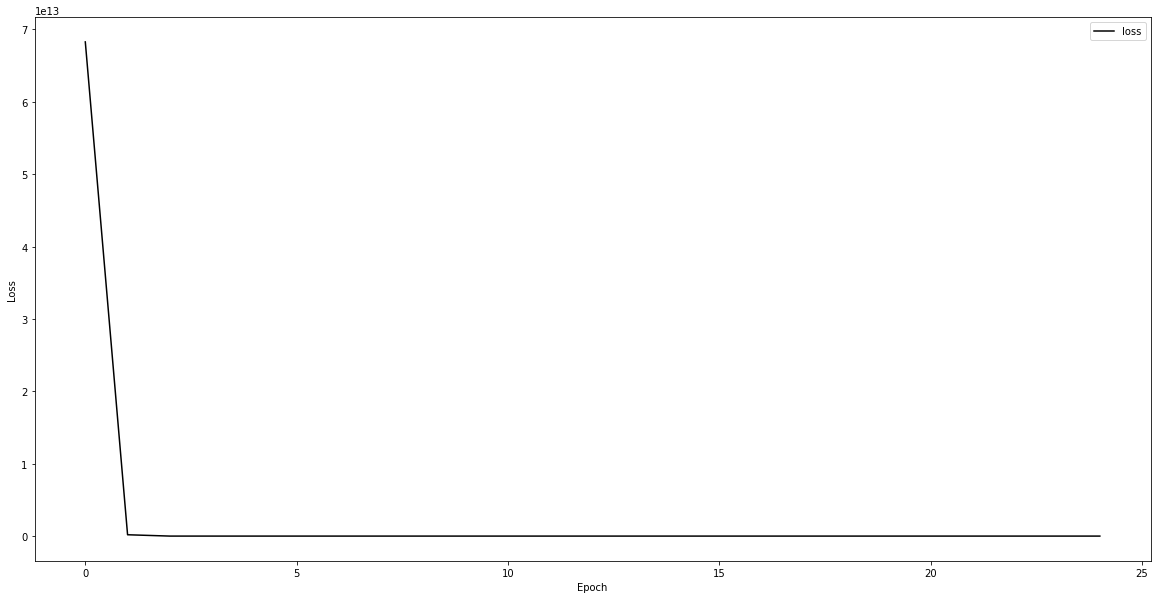

In [39]:
plt.plot(total_losses,"k",label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

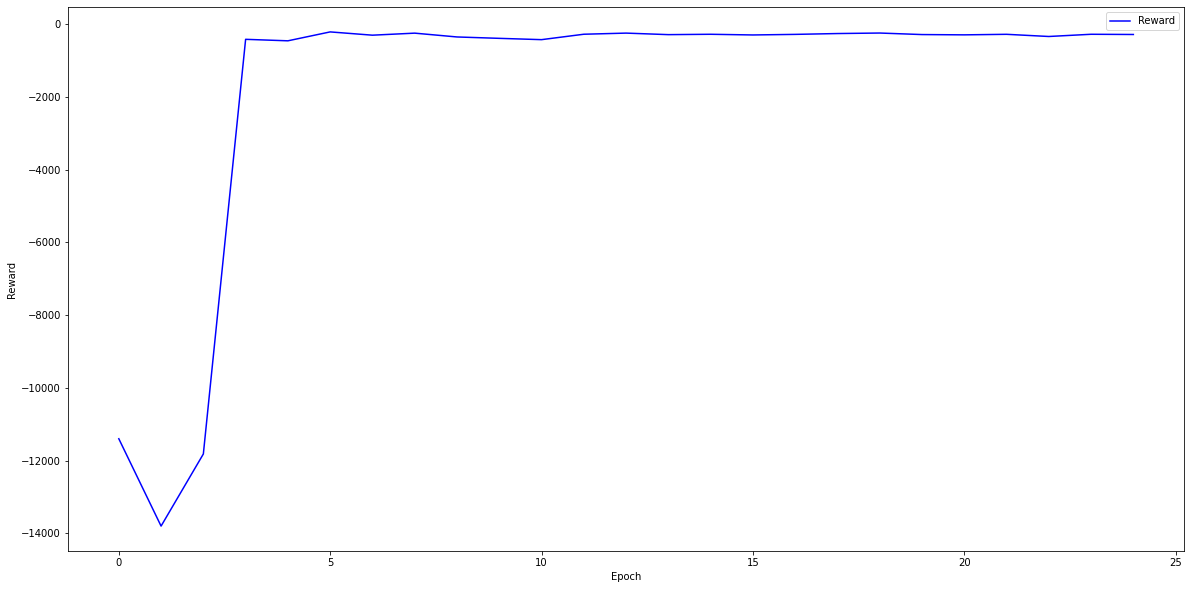

In [40]:
plt.plot(total_rewards,"b",label="Reward")
plt.xlabel("Epoch")
plt.ylabel("Reward")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,10)
plt.legend()
plt.show()

In [41]:
train_env,test_env = Environment1(train), Environment1(test)

# train
pobs = train_env.reset()
train_acts = []
train_rewards = []

for _ in range(len(train_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    train_acts.append(pact)

    obs, reward, done = train_env.step(pact)
    train_rewards.append(reward)

    pobs = obs

train_profits = train_env.profits

# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    test_acts.append(pact)

    obs, reward, done = test_env.step(pact)
    test_rewards.append(reward)

    pobs = obs

test_profits = test_env.profits
pobs = train_env.reset()
train_acts = []
train_rewards = []

for _ in range(len(train_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    train_acts.append(pact)

    obs, reward, done = train_env.step(pact)
    train_rewards.append(reward)

    pobs = obs

train_profits = train_env.profits

# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data) - 1):
    pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
    pact = np.argmax(pact.data)
    test_acts.append(pact)

    obs, reward, done = test_env.step(pact)
    test_rewards.append(reward)

    pobs = obs

test_profits = test_env.profits

In [42]:
train_copy = train_env.data.copy()
test_copy = test_env.data.copy()
train_copy['act'] = train_acts + [np.nan]
train_copy['reward'] = train_rewards + [np.nan]
test_copy['act'] = test_acts + [np.nan]
test_copy['reward'] = test_rewards + [np.nan]
train0 = train_copy[train_copy['act'] == 0]
train1 = train_copy[train_copy['act'] == 1]
train2 = train_copy[train_copy['act'] == 2]
test0 = test_copy[test_copy['act'] == 0]
test1 = test_copy[test_copy['act'] == 1]
test2 = test_copy[test_copy['act'] == 2]

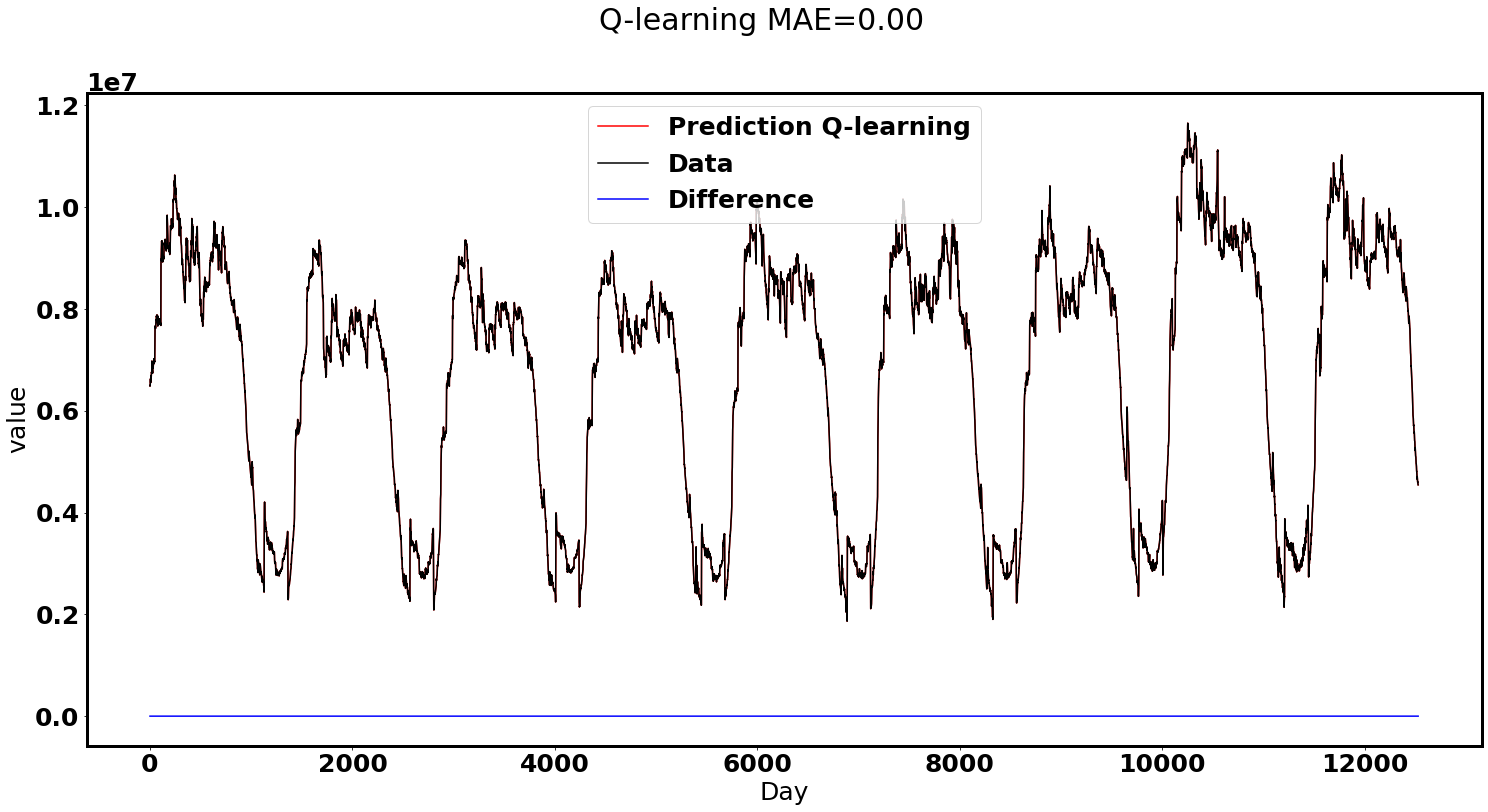

In [58]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

y1 = test0['cif']
y2 = test["cif"]
y2 = y2[:len(y1)].values

plt.plot(np.arange(0,len(y1),1),y1,"r",label="Prediction Q-learning")
plt.plot(np.arange(0,len(y1),1),y2,"k",label="Data")
plt.plot(np.arange(0,len(y1),1),y1-y2,"b",label="Difference")
plt.xlabel("Day")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Q-learning MAE=%.2f"%np.nanmean(abs(y1-y2[:len(y1)])))

fig = matplotlib.pyplot.gcf()
plt.legend()

fig.set_size_inches(25,12)
plt.savefig(plot_path+"CIF_Q_learning.png")





In [46]:
print("All set")

All set
